In [3]:
import os
import sys

sys.path.append("C:/Users/user/Desktop/SDP/cs-sdp-2023-24-main/python")

import matplotlib.pyplot as plt
import numpy as np

In [4]:
from data import Dataloader
from models_5 import HeuristicModel , RandomExampleModel
import metrics

In [5]:
# Loading the data
data_loader = Dataloader("C:/Users/user/Desktop/SDP/cs-sdp-2023-24-main/data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [7]:
# Let's train an example model
model = HeuristicModel( 3 ) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40185 rows, 160188 columns and 1473312 nonzeros
Model fingerprint: 0x7952cd77
Coefficient statistics:
  Matrix range     [5e-06, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+00]
Presolve removed 60 rows and 120036 columns
Presolve time: 1.60s
Presolved: 150 rows, 40275 columns, 1168628 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 3.675e+03
 Factor NZ  : 3.825e+03 (roughly 16 MB of memory)
 Factor Ops : 1.288e+05 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal      

In [8]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.07027449  0.09769558 -0.11754502]
 [ 0.11853493 -0.12264326 -0.029474  ]
 [ 0.06844049 -0.36323397  0.05700234]
 [-0.03526873  0.12233244  0.26777699]
 [ 0.08595539  0.08991109 -0.0888456 ]]


In [9]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 1 0]
 [1 0 0]
 [1 0 1]
 [0 1 1]
 [1 1 0]]


In [10]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [11]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.9824508774561272
Percentage of explained preferences for all samples: 0.9824508774561272


In [12]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[1 0 0 2 1]


In [13]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[1 0 2 1 0]


In [14]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.7956039887063421
Cluster intersection for all samples: 0.7956039887063421


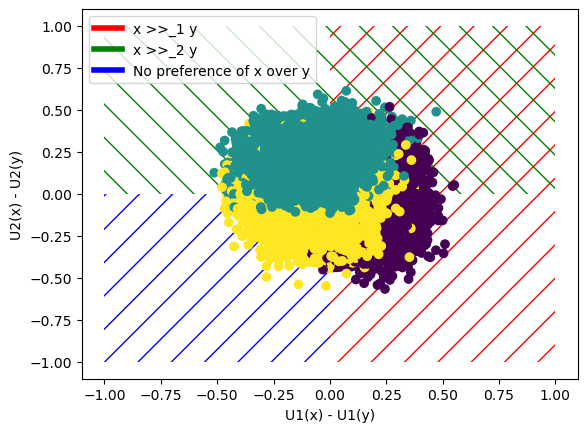

In [15]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [16]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5,
              "n_clusters" : 2} # Can be completed
# model = TwoClustersMIP(**parameters)
# model.fit(X, Y, plot=True)

# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Percentage of explained preferences on train data: 0.9824508774561272
Percentage of preferences well regrouped into clusters: 0.7956039887063421


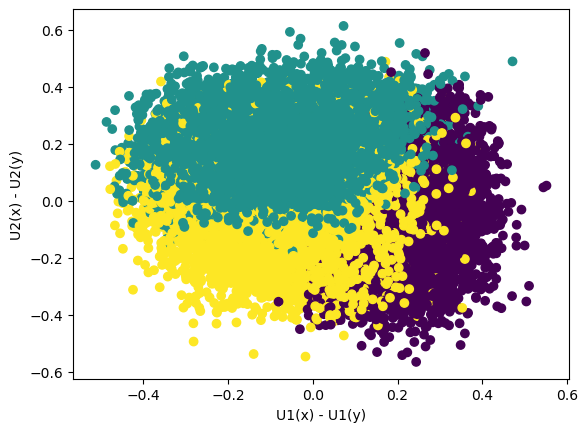

In [17]:
# As an example here are the results obtained with:
# Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()

# Here is how it should look like
# from IPython.display import Image
# Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.

In [18]:
import os
import sys

sys.path.append("C:/Users/user/Desktop/SDP/cs-sdp-2023-24-main/python")

import matplotlib.pyplot as plt
import numpy as np
from data import Dataloader
from models_5 import HeuristicModel
import metrics
# Loading the data
data_loader = Dataloader("C:/Users/user/Desktop/SDP/cs-sdp-2023-24-main/data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [19]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
cluster_intersection = metrics.ClusterIntersection()


In [22]:
from models_5 import HeuristicModel, TwoClustersMIP

model = HeuristicModel(3)
model.fit(X, Y)
Z = data_loader.get_ground_truth_labels()

# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40185 rows, 160188 columns and 1473312 nonzeros
Model fingerprint: 0x7952cd77
Coefficient statistics:
  Matrix range     [5e-06, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+00]
Presolve removed 60 rows and 120036 columns
Presolve time: 1.48s
Presolved: 150 rows, 40275 columns, 1168628 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 3
 AA' NZ     : 3.675e+03
 Factor NZ  : 3.825e+03 (roughly 16 MB of memory)
 Factor Ops : 1.288e+05 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal      